# Evaluation using QCB chemicals (medium)

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from os.path import exists
import copy

sys.path.append('../..')

In [3]:
import pylab as plt
import pandas as pd
import numpy as np
from loguru import logger
import seaborn as sns

from stable_baselines3 import DQN, PPO
from sb3_contrib import RecurrentPPO, MaskablePPO

In [4]:
from vimms.Common import POSITIVE, set_log_level_warning, load_obj, save_obj
from vimms.ChemicalSamplers import UniformRTAndIntensitySampler, GaussianChromatogramSampler, UniformMZFormulaSampler, \
    MZMLFormulaSampler, MZMLRTandIntensitySampler, MZMLChromatogramSampler
from vimms.Noise import UniformSpikeNoise
from vimms.Evaluation import evaluate_real
from vimms.Chemicals import ChemicalMixtureFromMZML
from vimms.Roi import RoiBuilderParams, SmartRoiParams

from mass_spec_utils.data_import.mzmine import load_picked_boxes

from vimms_gym.env import DDAEnv
from vimms_gym.chemicals import generate_chemicals
from vimms_gym.evaluation import evaluate, run_method
from vimms_gym.common import METHOD_RANDOM, METHOD_FULLSCAN, METHOD_TOPN, METHOD_DQN, \
    METHOD_DQN_COV, METHOD_DQN_INT, METHOD_DQN_MID, METHOD_PPO, METHOD_PPO_RECURRENT
from vimms_gym.experiments import preset_qcb_medium

# 1. Parameters

Parameters that will be used throughout this notebook. Should be the same as the training ones.

Chemical generation parameters

In [5]:
env_alpha = 0.25
env_beta = 0.50
extract = True
params, max_peaks = preset_qcb_medium(None, alpha=env_alpha, beta=env_beta, extract_chromatograms=extract)
params, max_peaks

2023-04-10 21:45:20.184 | INFO     | vimms_gym.experiments:get_samplers:303 - Loaded /Users/joewandy/Work/git/vimms-gym/pickles/samplers_QCB_medium_extracted.p


({'chemical_creator': {'mz_range': (100, 600),
   'rt_range': (400, 800),
   'intensity_range': (10000.0, 1e+20),
   'n_chemicals': (200, 500),
   'mz_sampler': <vimms.ChemicalSamplers.MZMLFormulaSampler at 0x7fe1da66b7c0>,
   'ri_sampler': <vimms.ChemicalSamplers.MZMLRTandIntensitySampler at 0x7fe1da6d5180>,
   'cr_sampler': <vimms.ChemicalSamplers.MZMLChromatogramSampler at 0x7fe1da6ee320>},
  'noise': {'enable_spike_noise': True,
   'noise_density': 0.1,
   'noise_max_val': 1000.0,
   'mz_range': (100, 600)},
  'env': {'ionisation_mode': 'Positive',
   'rt_range': (400, 800),
   'isolation_window': 0.7,
   'use_dew': False,
   'mz_tol': 10,
   'rt_tol': 5,
   'min_ms1_intensity': 5000,
   'alpha': 0.25,
   'beta': 0.5}},
 30)

In [6]:
# n_chemicals = (200, 500)
# mz_range = (100, 600)
# rt_range = (400, 800)
# intensity_range = (1E4, 1E20)

Evaluation parameters

In [7]:
env_name = 'DDAEnv'
intensity_threshold = 0.5

dqn_in_dir = 'DQN_1.0E6'

# ppo_in_dir = os.path.join('..', '..', 'tune', 'QCB_resimulated_medium')
ppo_in_dir = 'PPO_1.0E6'

methods = [
    METHOD_RANDOM,
    METHOD_TOPN,
]
valid_random = True
n_eval_episodes = 30

In [8]:
# topN parameters
topN_N = 10
topN_rt_tol = 5
min_ms1_intensity = 5000

# smartroi parameters
alpha = 2
beta = 0.5
ils = 0
smartroi_N = topN_N
smartroi_dew = topN_rt_tol

# weighteddew parameters
t0 = 3
t1 = 15
weighteddew_N = 10

## Generate chemical sets for evaluation

In [9]:
fname = 'QCB_chems_medium.p'
found = exists(fname)
if found:
    chem_list = load_obj(fname)
    for chems in chem_list:
        print(len(chems))

426
262
394
452
437
200
478
204
424
384
443
249
251
300
206
407
498
372
302
265
468
234
322
310
345
396
203
281
493
304


Generate new chemicals if not found

In [10]:
params['chemical_creator']

{'mz_range': (100, 600),
 'rt_range': (400, 800),
 'intensity_range': (10000.0, 1e+20),
 'n_chemicals': (200, 500),
 'mz_sampler': <vimms.ChemicalSamplers.MZMLFormulaSampler at 0x7fe1da66b7c0>,
 'ri_sampler': <vimms.ChemicalSamplers.MZMLRTandIntensitySampler at 0x7fe1da6d5180>,
 'cr_sampler': <vimms.ChemicalSamplers.MZMLChromatogramSampler at 0x7fe1da6ee320>}

In [11]:
if not found:
    repeat = 30
    logger.warning('Generating chemicals')
    
    chemical_creator_params = params['chemical_creator']
    chem_list = []
    for i in range(repeat):
        chems = generate_chemicals(chemical_creator_params)
        print(len(chems))
        chem_list.append(chems)
        
    save_obj(chem_list, fname)

In [12]:
chem_list = chem_list[0:n_eval_episodes]
len(chem_list)

30

# 2. Evaluation

In [13]:
set_log_level_warning()

1

In [14]:
params

{'chemical_creator': {'mz_range': (100, 600),
  'rt_range': (400, 800),
  'intensity_range': (10000.0, 1e+20),
  'n_chemicals': (200, 500),
  'mz_sampler': <vimms.ChemicalSamplers.MZMLFormulaSampler at 0x7fe1da66b7c0>,
  'ri_sampler': <vimms.ChemicalSamplers.MZMLRTandIntensitySampler at 0x7fe1da6d5180>,
  'cr_sampler': <vimms.ChemicalSamplers.MZMLChromatogramSampler at 0x7fe1da6ee320>},
 'noise': {'enable_spike_noise': True,
  'noise_density': 0.1,
  'noise_max_val': 1000.0,
  'mz_range': (100, 600)},
 'env': {'ionisation_mode': 'Positive',
  'rt_range': (400, 800),
  'isolation_window': 0.7,
  'use_dew': False,
  'mz_tol': 10,
  'rt_tol': 5,
  'min_ms1_intensity': 5000,
  'alpha': 0.25,
  'beta': 0.5}}

In [15]:
horizon = 1
out_dir = 'evaluation_1.0E6_horizon_%d_alpha_%.2f_beta_%.2f' % (horizon, env_alpha, env_beta)

In [16]:
method_eval_results = {}
for method in methods:

    N = 0
    copy_params = copy.deepcopy(params)            
    custom_objects = {
        "learning_rate": 0.0,
        "lr_schedule": lambda _: 0.0,
        "clip_range": lambda _: 0.0,
    }    
    
    model = None
    if method == METHOD_TOPN:
        N = topN_N
        effective_rt_tol = topN_rt_tol
        copy_params['env']['use_dew'] = True
        copy_params['env']['rt_tol'] = effective_rt_tol                        

    banner = 'method = %s max_peaks = %d N = %d rt_tol = %d' % (method, max_peaks, N, 
                                                                                   copy_params['env']['rt_tol'])
    print(banner)
    print()            
            
    episodic_results = run_method(env_name, copy_params, max_peaks, chem_list, method, out_dir, 
                                  N=N, min_ms1_intensity=min_ms1_intensity, model=model,
                                  print_eval=True, print_reward=True, intensity_threshold=intensity_threshold,
                                  mzml_prefix=method, horizon=horizon, valid_random=valid_random)
    eval_results = [er.eval_res for er in episodic_results]
    method_eval_results[method] = eval_results
    print()

method = random max_peaks = 30 N = 0 rt_tol = 5


Episode 0 (426 chemicals)
steps	 500 	total rewards	 103.79073780552237
steps	 1000 	total rewards	 114.06120179719899
steps	 1500 	total rewards	 110.78517334938425
Finished after 1792 timesteps (1.9035470485687256 seconds) with total reward 88.04525624924396
{'coverage_prop': '0.944', 'intensity_prop': '0.698', 'ms1ms2_ratio': '0.131', 'efficiency': '0.254', 'TP': '339', 'FP': '63', 'FN': '24', 'precision': '0.843', 'recall': '0.934', 'f1': '0.886', 'total_rewards': 88.04525624924385, 'invalid_action_count': 0, 'num_ms1_scans': 208, 'num_ms2_scans': 1584}

Episode 1 (262 chemicals)
steps	 500 	total rewards	 135.34679416088014
steps	 1000 	total rewards	 190.05591625757498
steps	 1500 	total rewards	 178.27689267353597
Finished after 1699 timesteps (1.2746341228485107 seconds) with total reward 166.67489058510085
{'coverage_prop': '0.947', 'intensity_prop': '0.774', 'ms1ms2_ratio': '0.215', 'efficiency': '0.177', 'TP': '231', 'FP': '1

#### DQN

In [17]:
import argparse
import os
import random
import socket
import time
from datetime import datetime
from distutils.util import strtobool
from typing import Callable

import gymnasium as gym
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from gymnasium.utils.env_checker import check_env
from stable_baselines3.common.buffers import ReplayBuffer
from torch.utils.tensorboard import SummaryWriter
from vimms.Common import load_obj
from vimms.Evaluation import EvaluationData

from vimms_gym.common import METHOD_DQN, evaluate
from vimms_gym.env import DDAEnv
from vimms_gym.experiments import preset_qcb_medium
from vimms_gym.wrappers import custom_flatten_dict_observations
from model.DQN import QNetwork, make_env, masked_epsilon_greedy

In [18]:
device = torch.device("cpu")
device

device(type='cpu')

In [19]:
model_path = os.path.join(dqn_in_dir, 'DQN.model')
model_path

'DQN_1.0E6/DQN.model'

In [20]:
env_id = 'DDAEnv'
Model = QNetwork

In [21]:
envs = gym.vector.SyncVectorEnv([make_env(env_id, 0, max_peaks, params)])
model = Model(envs).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

/opt/anaconda3/envs/vimms-gym/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:42: UserWarning:

WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (30, 10)

/opt/anaconda3/envs/vimms-gym/lib/python3.10/site-packages/gymnasium/utils/env_checker.py:317: UserWarning:

WARN: Not able to test alternative render modes due to the environment not having a spec. Try instantialising the environment through gymnasium.make



QNetwork(
  (roi_network): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=64, out_features=64, bias=True)
    (8): ReLU()
  )
  (output_layer): Linear(in_features=1984, out_features=31, bias=True)
  (other_network): Sequential(
    (0): Linear(in_features=277, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
  )
)

In [22]:
eval_episodes = n_eval_episodes
eval_episodes, len(chem_list)

(30, 30)

In [23]:
episodic_returns = []
evaluation_results = []
for i in range(len(chem_list)):
    if i >= eval_episodes:
        break

    chems = chem_list[i]

    obs, info = envs.reset(options={'chems': chems})
    done = False
    eval_data = None
    while not done:
        env = envs.envs[0].env
        actions = masked_epsilon_greedy(device, max_peaks, None, obs, model,
                                        deterministic=True)

        next_obs, rewards, terminateds, truncateds, infos = envs.step(actions)
        dones = terminateds

        if 'final_info' in infos:
            final_infos = infos['final_info']
            assert len(final_infos) == 1
            info = final_infos[0]
            episodic_return = info['episode']['r'][0]
            episodic_length = info['episode']['l'][0]

            eval_res = evaluate(eval_data)
            eval_res['invalid_action_count'] = env.invalid_action_count
            eval_res['total_rewards'] = episodic_return
            eval_res['episodic_length'] = episodic_length
            eval_res['num_ms1_scans'] = len(eval_data.controller.scans[1])
            eval_res['num_ms2_scans'] = len(eval_data.controller.scans[2])
            evaluation_results.append(eval_res)

            print(
                f'Episode {i} ({len(chems)} chemicals) return {episodic_return} length {episodic_length}')
            print(eval_res)

            episodic_returns += [episodic_return]
            
            mzml_name = METHOD_DQN
            out_file = '%s_%d.mzML' % (mzml_name, i)
            vimms_env.write_mzML(out_dir, out_file)            

        obs = next_obs
        done = dones[0]

        # store previous results for evaluation before 'done'
        # this needs to be here, because VecEnv is automatically reset when done
        vimms_env = env.env.vimms_env
        eval_data = EvaluationData(vimms_env)

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


Episode 0 (426 chemicals) return 336.8183898925781 length 1761
{'coverage_prop': '0.948', 'intensity_prop': '0.744', 'ms1ms2_ratio': '0.157', 'efficiency': '0.265', 'TP': '353', 'FP': '51', 'FN': '22', 'precision': '0.874', 'recall': '0.941', 'f1': '0.906', 'invalid_action_count': 0, 'total_rewards': 336.8184, 'episodic_length': 1761, 'num_ms1_scans': 239, 'num_ms2_scans': 1522}
Episode 1 (262 chemicals) return 427.56982421875 length 1692
{'coverage_prop': '0.950', 'intensity_prop': '0.805', 'ms1ms2_ratio': '0.223', 'efficiency': '0.180', 'TP': '235', 'FP': '14', 'FN': '13', 'precision': '0.944', 'recall': '0.948', 'f1': '0.946', 'invalid_action_count': 0, 'total_rewards': 427.56982, 'episodic_length': 1692, 'num_ms1_scans': 308, 'num_ms2_scans': 1384}
Episode 2 (394 chemicals) return 383.2319641113281 length 1735
{'coverage_prop': '0.947', 'intensity_prop': '0.731', 'ms1ms2_ratio': '0.180', 'efficiency': '0.254', 'TP': '326', 'FP': '47', 'FN': '21', 'precision': '0.874', 'recall': '0.

In [24]:
method_eval_results[METHOD_DQN] = evaluation_results

#### Test classic controllers in ViMMS

In [25]:
from vimms.MassSpec import IndependentMassSpectrometer
from vimms.Controller import TopNController, TopN_SmartRoiController, WeightedDEWController
from vimms.Environment import Environment

Run Top-N Controller

In [26]:
params

{'chemical_creator': {'mz_range': (100, 600),
  'rt_range': (400, 800),
  'intensity_range': (10000.0, 1e+20),
  'n_chemicals': (200, 500),
  'mz_sampler': <vimms.ChemicalSamplers.MZMLFormulaSampler at 0x7fe1da66b7c0>,
  'ri_sampler': <vimms.ChemicalSamplers.MZMLRTandIntensitySampler at 0x7fe1da6d5180>,
  'cr_sampler': <vimms.ChemicalSamplers.MZMLChromatogramSampler at 0x7fe1da6ee320>},
 'noise': {'enable_spike_noise': True,
  'noise_density': 0.1,
  'noise_max_val': 1000.0,
  'mz_range': (100, 600)},
 'env': {'ionisation_mode': 'Positive',
  'rt_range': (400, 800),
  'isolation_window': 0.7,
  'use_dew': False,
  'mz_tol': 10,
  'rt_tol': 5,
  'min_ms1_intensity': 5000,
  'alpha': 0.25,
  'beta': 0.5}}

In [27]:
enable_spike_noise = params['noise']['enable_spike_noise']
ionisation_mode = params['env']['ionisation_mode']
isolation_window = params['env']['isolation_window']
mz_tol = params['env']['mz_tol']
rt_range = params['chemical_creator']['rt_range']

In [28]:
method = 'TopN_Controller'
print('method = %s' % method)
print()

effective_rt_tol = topN_rt_tol
effective_N = topN_N
eval_results = []
for i in range(len(chem_list)):
    
    spike_noise = None
    if enable_spike_noise:
        noise_params = params['noise']
        noise_density = noise_params['noise_density']
        noise_max_val = noise_params['noise_max_val']
        noise_min_mz = noise_params['mz_range'][0]
        noise_max_mz = noise_params['mz_range'][1]
        spike_noise = UniformSpikeNoise(noise_density, noise_max_val, min_mz=noise_min_mz,
                                        max_mz=noise_max_mz)

    chems = chem_list[i]
    mass_spec = IndependentMassSpectrometer(ionisation_mode, chems, spike_noise=spike_noise)
    controller = TopNController(ionisation_mode, effective_N, isolation_window, mz_tol, effective_rt_tol,
                                min_ms1_intensity)
    env = Environment(mass_spec, controller, rt_range[0], rt_range[1], progress_bar=False, out_dir=out_dir,
                      out_file='%s_%d.mzML' % (method, i), save_eval=True)
    env.run()
    
    eval_res = evaluate(env, intensity_threshold)
    # eval_res['total_rewards'] = 0
    eval_results.append(eval_res)
    print('Episode %d finished' % i)
    print(eval_res)
    print()
    
method_eval_results[method] = eval_results

method = TopN_Controller

Episode 0 finished
{'coverage_prop': '0.960', 'intensity_prop': '0.746', 'ms1ms2_ratio': '0.215', 'efficiency': '0.293', 'TP': '366', 'FP': '43', 'FN': '17', 'precision': '0.895', 'recall': '0.956', 'f1': '0.924'}

Episode 1 finished
{'coverage_prop': '0.962', 'intensity_prop': '0.791', 'ms1ms2_ratio': '0.442', 'efficiency': '0.237', 'TP': '236', 'FP': '16', 'FN': '10', 'precision': '0.937', 'recall': '0.959', 'f1': '0.948'}

Episode 2 finished
{'coverage_prop': '0.970', 'intensity_prop': '0.750', 'ms1ms2_ratio': '0.273', 'efficiency': '0.295', 'TP': '344', 'FP': '38', 'FN': '12', 'precision': '0.901', 'recall': '0.966', 'f1': '0.932'}

Episode 3 finished
{'coverage_prop': '0.956', 'intensity_prop': '0.758', 'ms1ms2_ratio': '0.226', 'efficiency': '0.313', 'TP': '395', 'FP': '37', 'FN': '20', 'precision': '0.914', 'recall': '0.952', 'f1': '0.933'}

Episode 4 finished
{'coverage_prop': '0.975', 'intensity_prop': '0.759', 'ms1ms2_ratio': '0.234', 'efficiency': '0

Run SmartROI Controller

In [29]:
smartroi_N, smartroi_dew, alpha, beta, ils

(10, 5, 2, 0.5, 0)

In [30]:
method = 'SmartROI_Controller'
print('method = %s' % method)
print()

eval_results = []
for i in range(len(chem_list)):
    
    spike_noise = None
    if enable_spike_noise:
        noise_params = params['noise']
        noise_density = noise_params['noise_density']
        noise_max_val = noise_params['noise_max_val']
        noise_min_mz = noise_params['mz_range'][0]
        noise_max_mz = noise_params['mz_range'][1]
        spike_noise = UniformSpikeNoise(noise_density, noise_max_val, min_mz=noise_min_mz,
                                        max_mz=noise_max_mz)

    chems = chem_list[i]
    mass_spec = IndependentMassSpectrometer(ionisation_mode, chems, spike_noise=spike_noise)
    
    roi_params = RoiBuilderParams(min_roi_intensity=0, min_roi_length=0)    
    smartroi_params = SmartRoiParams(intensity_increase_factor=alpha, drop_perc=beta/100.0, dew=smartroi_dew, initial_length_seconds=ils)
    controller = TopN_SmartRoiController(ionisation_mode, isolation_window, smartroi_N, mz_tol, smartroi_dew,
                                min_ms1_intensity, roi_params, smartroi_params)
    env = Environment(mass_spec, controller, rt_range[0], rt_range[1], progress_bar=False, out_dir=out_dir,
                      out_file='%s_%d.mzML' % (method, i), save_eval=True)
    env.run()
    
    eval_res = evaluate(env, intensity_threshold)
    # eval_res['total_rewards'] = 0
    eval_results.append(eval_res)
    print('Episode %d finished' % i)
    print(eval_res)
    print()    
    
method_eval_results[method] = eval_results

method = SmartROI_Controller

Episode 0 finished
{'coverage_prop': '0.977', 'intensity_prop': '0.709', 'ms1ms2_ratio': '0.795', 'efficiency': '0.539', 'TP': '360', 'FP': '56', 'FN': '10', 'precision': '0.865', 'recall': '0.973', 'f1': '0.916'}

Episode 1 finished
{'coverage_prop': '0.962', 'intensity_prop': '0.713', 'ms1ms2_ratio': '1.513', 'efficiency': '0.507', 'TP': '220', 'FP': '32', 'FN': '10', 'precision': '0.873', 'recall': '0.957', 'f1': '0.913'}

Episode 2 finished
{'coverage_prop': '0.970', 'intensity_prop': '0.708', 'ms1ms2_ratio': '0.850', 'efficiency': '0.516', 'TP': '324', 'FP': '58', 'FN': '12', 'precision': '0.848', 'recall': '0.964', 'f1': '0.903'}

Episode 3 finished
{'coverage_prop': '0.973', 'intensity_prop': '0.714', 'ms1ms2_ratio': '0.746', 'efficiency': '0.548', 'TP': '379', 'FP': '61', 'FN': '12', 'precision': '0.861', 'recall': '0.969', 'f1': '0.912'}

Episode 4 finished
{'coverage_prop': '0.991', 'intensity_prop': '0.723', 'ms1ms2_ratio': '0.779', 'efficiency'

Run WeightedDEW Controller

In [31]:
method = 'WeightedDEW_Controller'
print('method = %s' % method)
print()

eval_results = []
for i in range(len(chem_list)):
    
    spike_noise = None
    if enable_spike_noise:
        noise_params = params['noise']
        noise_density = noise_params['noise_density']
        noise_max_val = noise_params['noise_max_val']
        noise_min_mz = noise_params['mz_range'][0]
        noise_max_mz = noise_params['mz_range'][1]
        spike_noise = UniformSpikeNoise(noise_density, noise_max_val, min_mz=noise_min_mz,
                                        max_mz=noise_max_mz)

    chems = chem_list[i]
    mass_spec = IndependentMassSpectrometer(ionisation_mode, chems, spike_noise=spike_noise)
    
    controller = WeightedDEWController(ionisation_mode, weighteddew_N, isolation_window, mz_tol, t1,
                                min_ms1_intensity, exclusion_t_0=t0)
    env = Environment(mass_spec, controller, rt_range[0], rt_range[1], progress_bar=False, out_dir=out_dir,
                      out_file='%s_%d.mzML' % (method, i), save_eval=True)
    env.run()
    
    eval_res = evaluate(env, intensity_threshold)
    # eval_res['total_rewards'] = 0
    eval_results.append(eval_res)
    print('Episode %d finished' % i)
    print(eval_res)
    print()    
    
method_eval_results[method] = eval_results

method = WeightedDEW_Controller

Episode 0 finished
{'coverage_prop': '0.965', 'intensity_prop': '0.743', 'ms1ms2_ratio': '0.159', 'efficiency': '0.271', 'TP': '368', 'FP': '43', 'FN': '15', 'precision': '0.895', 'recall': '0.961', 'f1': '0.927'}

Episode 1 finished
{'coverage_prop': '0.958', 'intensity_prop': '0.791', 'ms1ms2_ratio': '0.242', 'efficiency': '0.186', 'TP': '238', 'FP': '13', 'FN': '11', 'precision': '0.948', 'recall': '0.956', 'f1': '0.952'}

Episode 2 finished
{'coverage_prop': '0.964', 'intensity_prop': '0.738', 'ms1ms2_ratio': '0.198', 'efficiency': '0.265', 'TP': '343', 'FP': '37', 'FN': '14', 'precision': '0.903', 'recall': '0.961', 'f1': '0.931'}

Episode 3 finished
{'coverage_prop': '0.969', 'intensity_prop': '0.762', 'ms1ms2_ratio': '0.158', 'efficiency': '0.288', 'TP': '404', 'FP': '34', 'FN': '14', 'precision': '0.922', 'recall': '0.967', 'f1': '0.944'}

Episode 4 finished
{'coverage_prop': '0.984', 'intensity_prop': '0.761', 'ms1ms2_ratio': '0.178', 'efficien

#### Plotting

Flatten data into dataframe

In [32]:
data = []
for method in method_eval_results:
    eval_results = method_eval_results[method]
    for eval_res in eval_results:
        try:
            total_rewards = float(eval_res['total_rewards'])       
        except KeyError:
            total_rewards = 0.0

        try:
            invalid_action_count = float(eval_res['invalid_action_count'])       
        except KeyError:
            invalid_action_count = 0.0

        row = (
            method, 
            total_rewards, 
            invalid_action_count,
            float(eval_res['coverage_prop']), 
            float(eval_res['intensity_prop']), 
            float(eval_res['ms1ms2_ratio']), 
            float(eval_res['efficiency']),
            float(eval_res['precision']),
            float(eval_res['recall']),
            float(eval_res['f1']),            
        )
        data.append(row)
        
df = pd.DataFrame(data, columns=['method', 'total_rewards', 'invalid_action_count', 
    'coverage_prop', 'intensity_prop', 'ms1/ms2_ratio', 'efficiency', 
    'precision', 'recall', 'f1'])
# df.set_index('method', inplace=True)
df.head()

,method,total_rewards,invalid_action_count,coverage_prop,intensity_prop,ms1/ms2_ratio,efficiency,precision,recall,f1
0,random,88.045256,0.0,0.944,0.698,0.131,0.254,0.843,0.934,0.886
1,random,166.674891,0.0,0.947,0.774,0.215,0.177,0.931,0.943,0.937
2,random,238.114767,0.0,0.947,0.727,0.164,0.248,0.882,0.940,0.910
3,random,180.992775,0.0,0.929,0.721,0.135,0.267,0.879,0.920,0.899
4,random,154.933284,0.0,0.952,0.709,0.153,0.272,0.853,0.944,0.896


In [33]:
sns.set_context("poster")

Text(0.5, 1.0, 'Total Rewards')

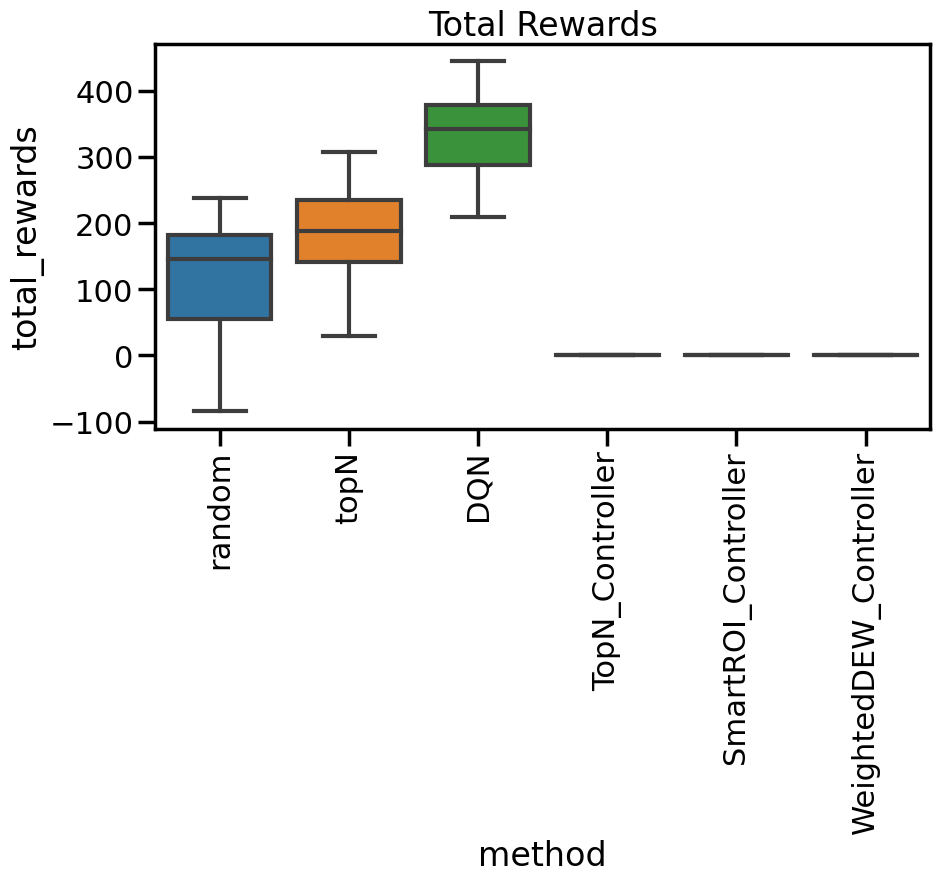

In [34]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='total_rewards')
plt.xticks(rotation=90)
plt.title('Total Rewards')

Text(0.5, 1.0, 'Invalid Action Count')

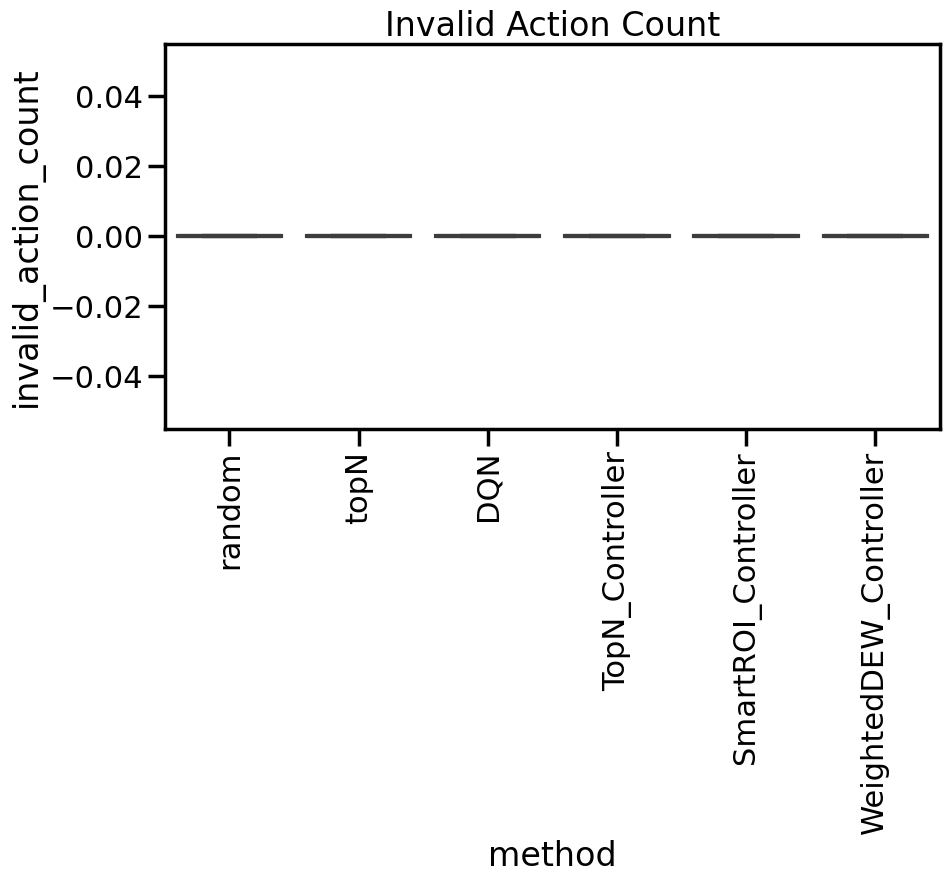

In [35]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='invalid_action_count')
plt.xticks(rotation=90)
plt.title('Invalid Action Count')

Text(0.5, 1.0, 'Coverage Proportion')

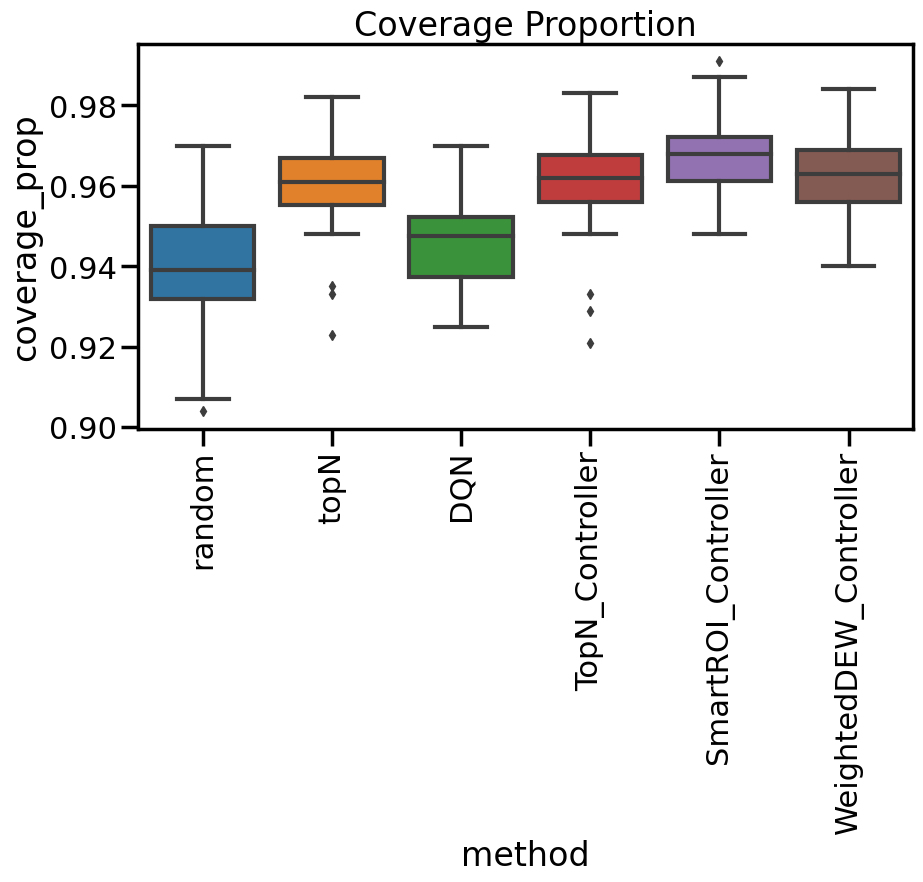

In [36]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='coverage_prop')
plt.xticks(rotation=90)
plt.title('Coverage Proportion')

Text(0.5, 1.0, 'Intensity Proportion')

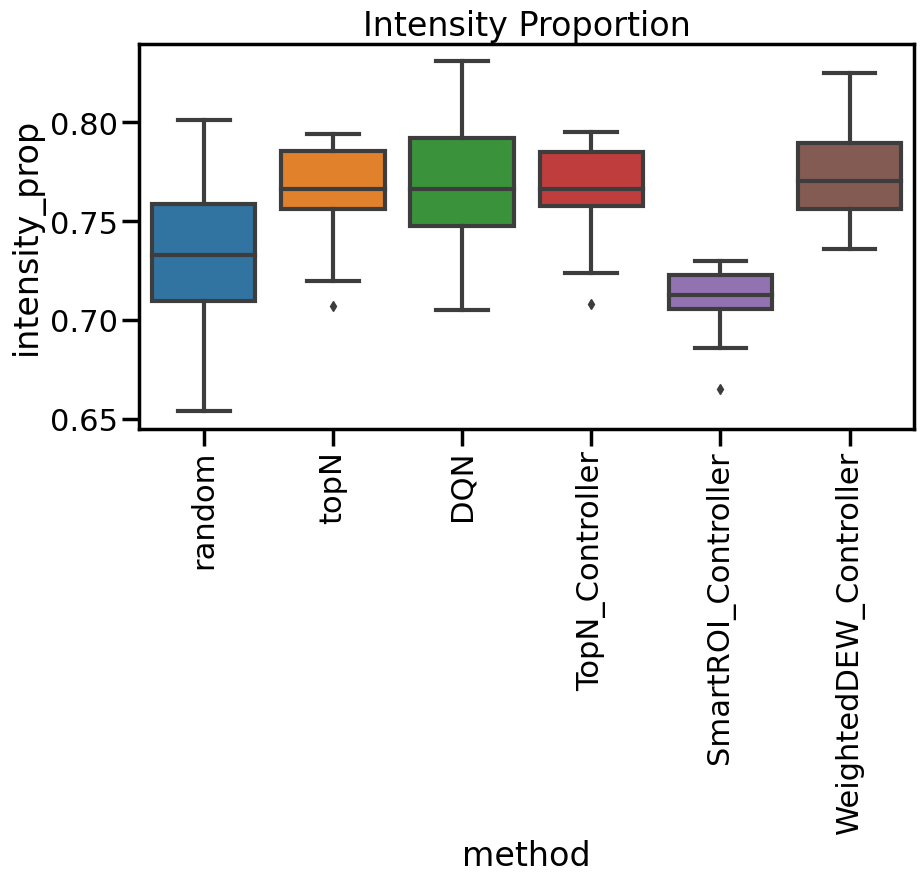

In [37]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='intensity_prop')
plt.xticks(rotation=90)
plt.title('Intensity Proportion')

Text(0.5, 1.0, 'MS1/MS2 Ratio')

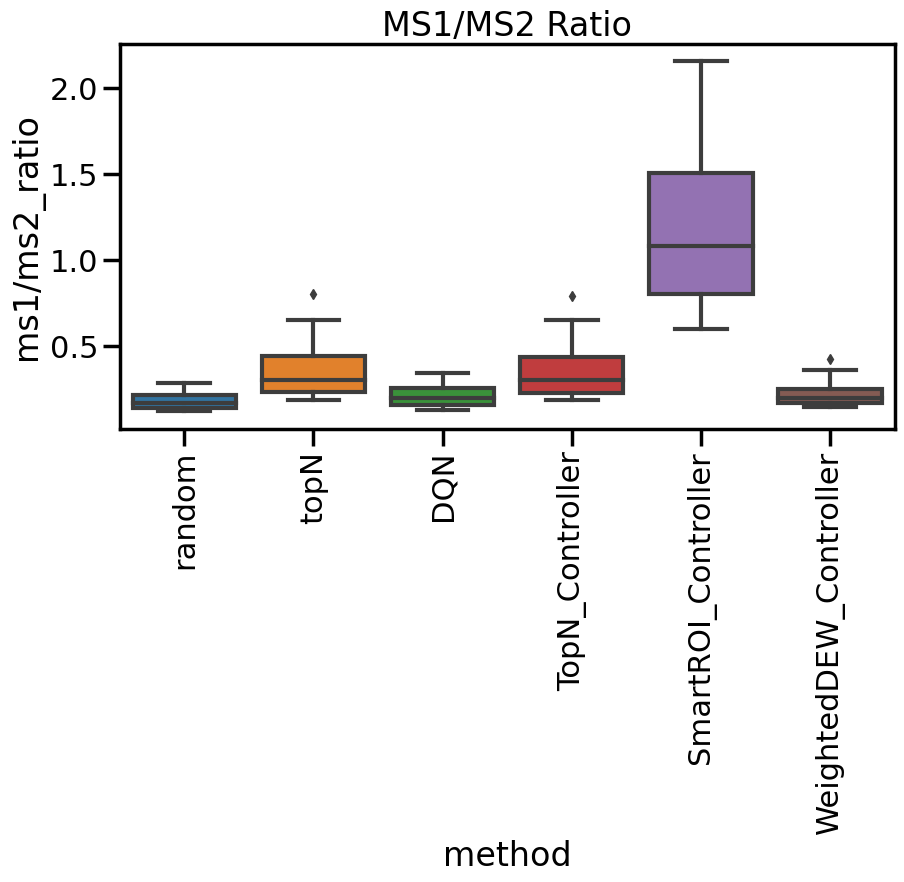

In [38]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='ms1/ms2_ratio')
plt.xticks(rotation=90)
plt.title('MS1/MS2 Ratio')

Text(0.5, 1.0, 'Efficiency')

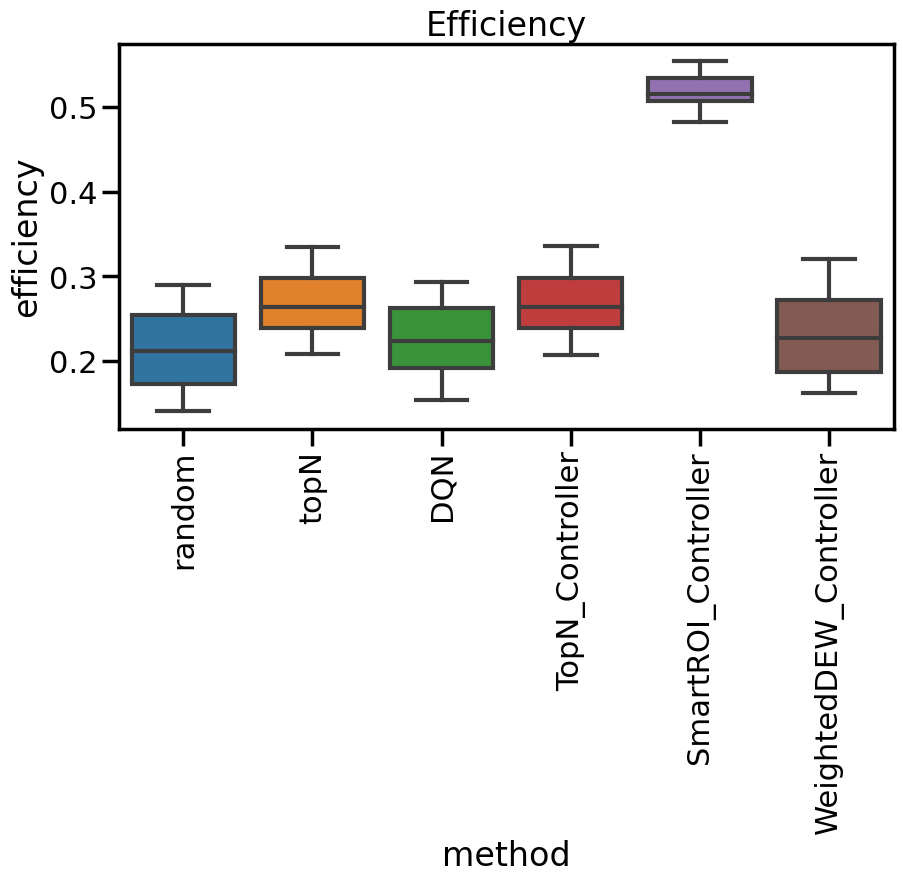

In [39]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='efficiency')
plt.xticks(rotation=90)
plt.title('Efficiency')

Text(0.5, 1.0, 'Precision')

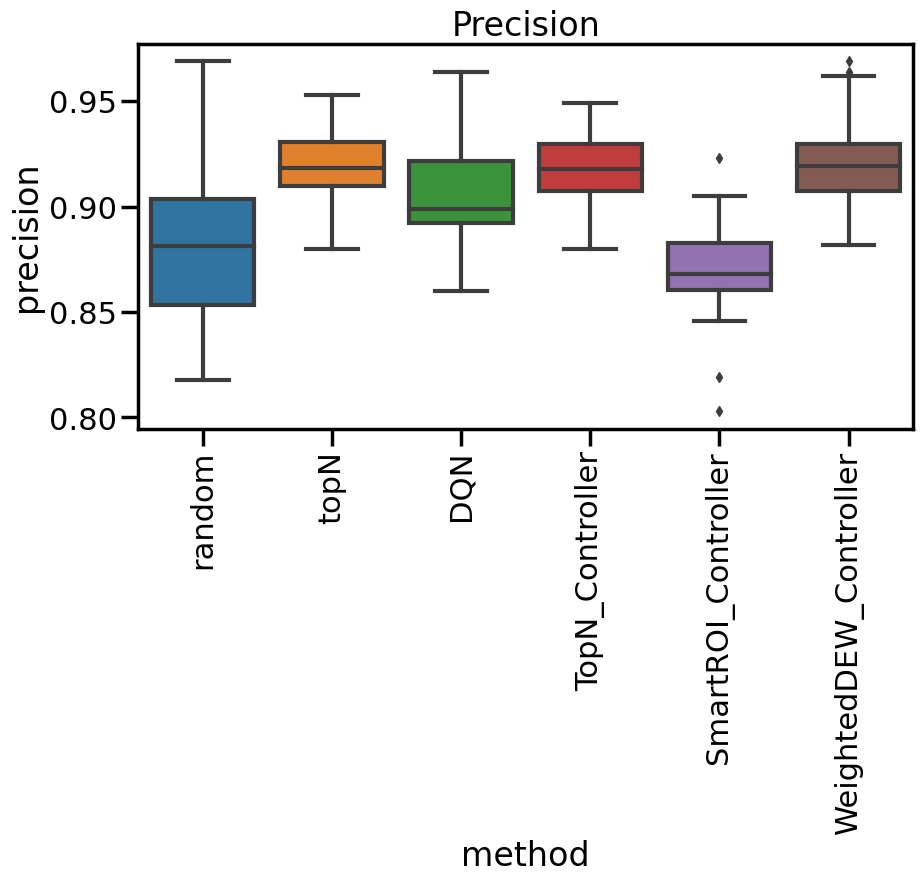

In [40]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='precision')
plt.xticks(rotation=90)
plt.title('Precision')

Text(0.5, 1.0, 'Recall')

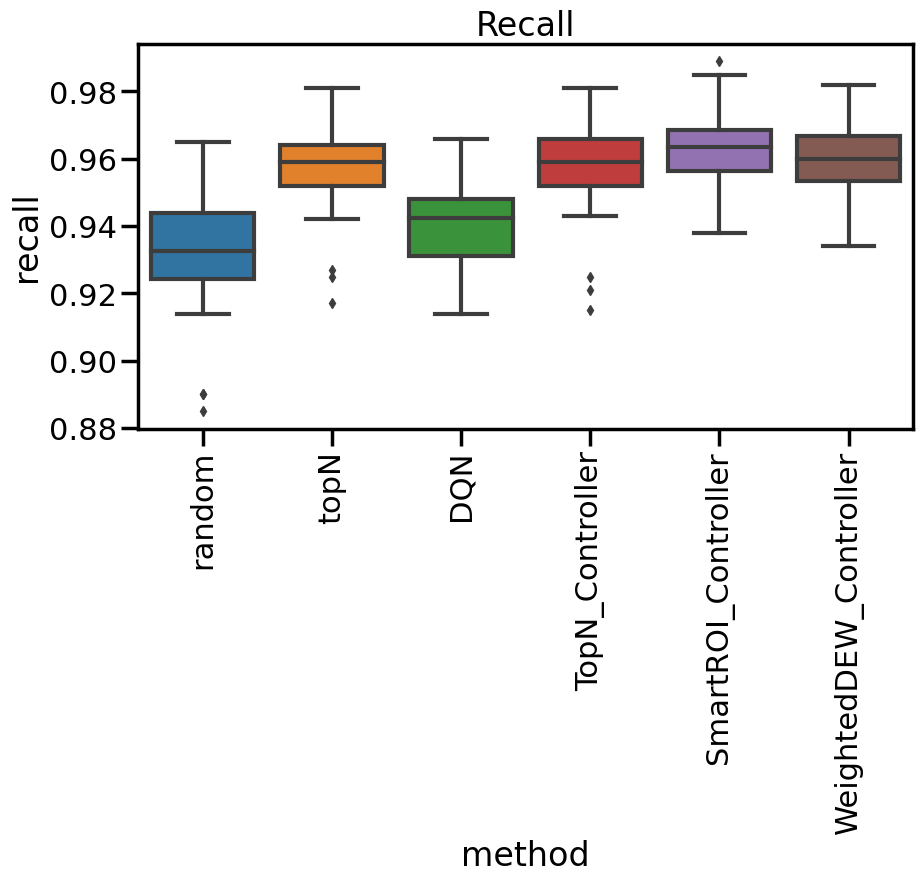

In [41]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='recall')
plt.xticks(rotation=90)
plt.title('Recall')

Text(0.5, 1.0, 'F1')

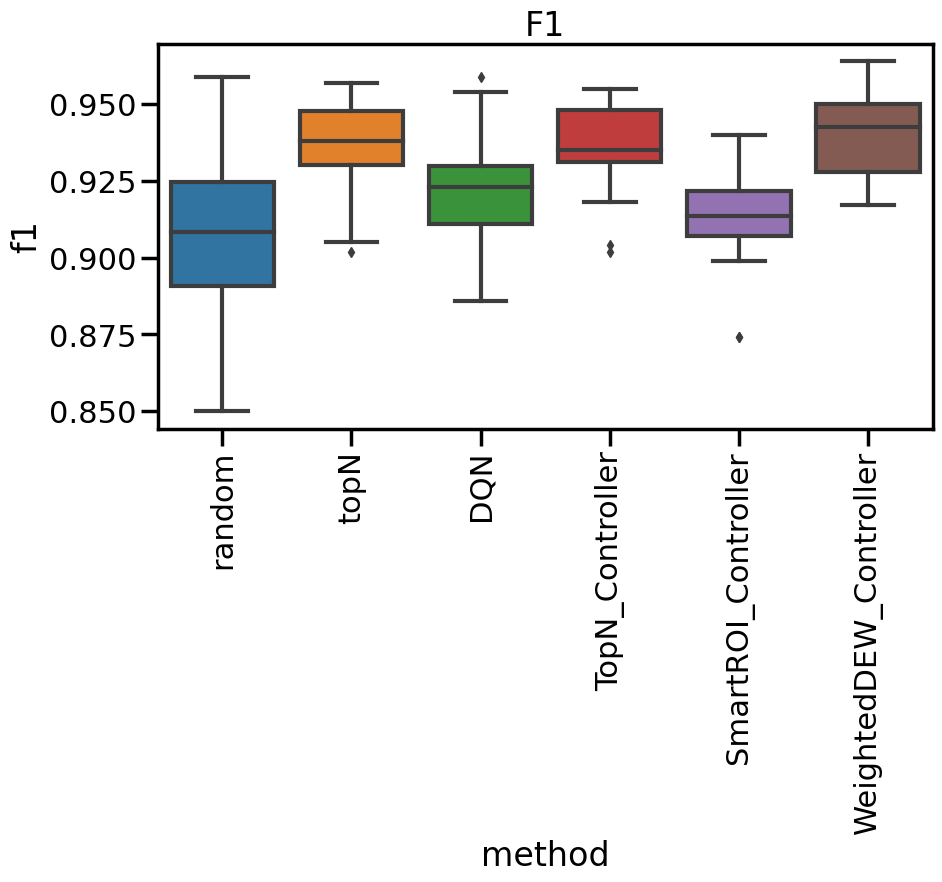

In [42]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='f1')
plt.xticks(rotation=90)
plt.title('F1')

In [43]:
df.to_pickle('evaluation_1.0E6_horizon_%d_alpha_%.2f_beta_%.2f.p' % (horizon, env_alpha, env_beta))